![image.png](image.png)

In [ ]:
# !virtualenv venv --python=python3
# !source venv/bin/activate
# !pip install numpy pandas
# Se necessário instalar o jupyter dentro do ambiente virtual:
# !pip install jupyter

# Uma análise sobre a maior comunidade de Board Games do mundo (BoardGameGeek)
### Por Rômulo Filho 

Como muito bem exemplificou o  **SP TV** da Rede Globo, nos últimos anos os jogos de tabuleiro tem se diversificado tanto em variedade de temas quanto em complexidade de sistemas. 

Dos tradicionais **Jogo da Vida** e **Banco Imobiliário**, passando por já clássicos como **Catan** e **Carcassone**, até chegar a jogos extremamente complexos com partidas que duram várias horas. FALAR NOMES DE JOGOS COMPELXOS

Com um universo de possibilidades que cresce mais a cada dia, os "Boardgamers" se organizaram em comunidades tanto locais ao redor de luderias quanto online. No Brasil, a mais famosa é a Ludopedia, que segue o formato do BoardGameGeek (BGG). Este último é a maior rede social de jogos de tabuleiro do mundo.

Dessa forma, busco com este trabalho analisar um conjunto de dados do BGG disponível no [Kaggle](https://www.kaggle.com/gabrio/board-games-dataset) e responder as seguintes perguntas:
- Quais os jogos mais bem avaliados?
- Quem são os melhores Game Designers?
- O que define um bom jogo de tabuleiro?
- Existe uma quantidade ideal de jogadores que influencie na nota?
- A duração de uma partida influencia na nota?
- Qual a influência da dificuldade na nota?

In [ ]:
import sys
import sqlite3

import seaborn as sn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# np.set_printoptions(threshold=np.inf)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [ ]:
db_sql = sqlite3.connect('database.sqlite')

df = pd.read_sql_query("SELECT * FROM BoardGames", db_sql)
# print(df.head())
print(df.shape)
db_sql.close()

In [ ]:
df

### Pré-processamento

In [ ]:
# Removendo expansões
print(df['game.type'].unique(), df.shape)
df = df[df['game.type']=='boardgame']
print(df['game.type'].unique(), df.shape)
# Como vemos no segundo print as expansões foram removidas

In [ ]:
# Removendo jogos não publicados e com menos de 5 avaliações
df.dropna(axis=0, subset=['details.yearpublished', ], inplace=True)
df = df[df['stats.usersrated'] >= 10]
df.shape

In [ ]:
# Removendo colunas indesejadas
for col in df:
    if 'polls' in col or 'family' in col or 'subtype' in col:
        df.drop(col, axis=1, inplace=True)
        
df.drop('details.description', axis=1, inplace=True)
df.drop('details.image', axis=1, inplace=True)
df.drop('attributes.t.links.concat.2....', axis=1, inplace=True)
df.drop('details.thumbnail', axis=1, inplace=True)


In [ ]:
# Investigando 
# df2 = df.set_index('details.name')
df2 = df.set_index('attributes.boardgamedesigner')

df2.loc['Mauro Pane']

## Quais são os jogos mais bem avaliados?

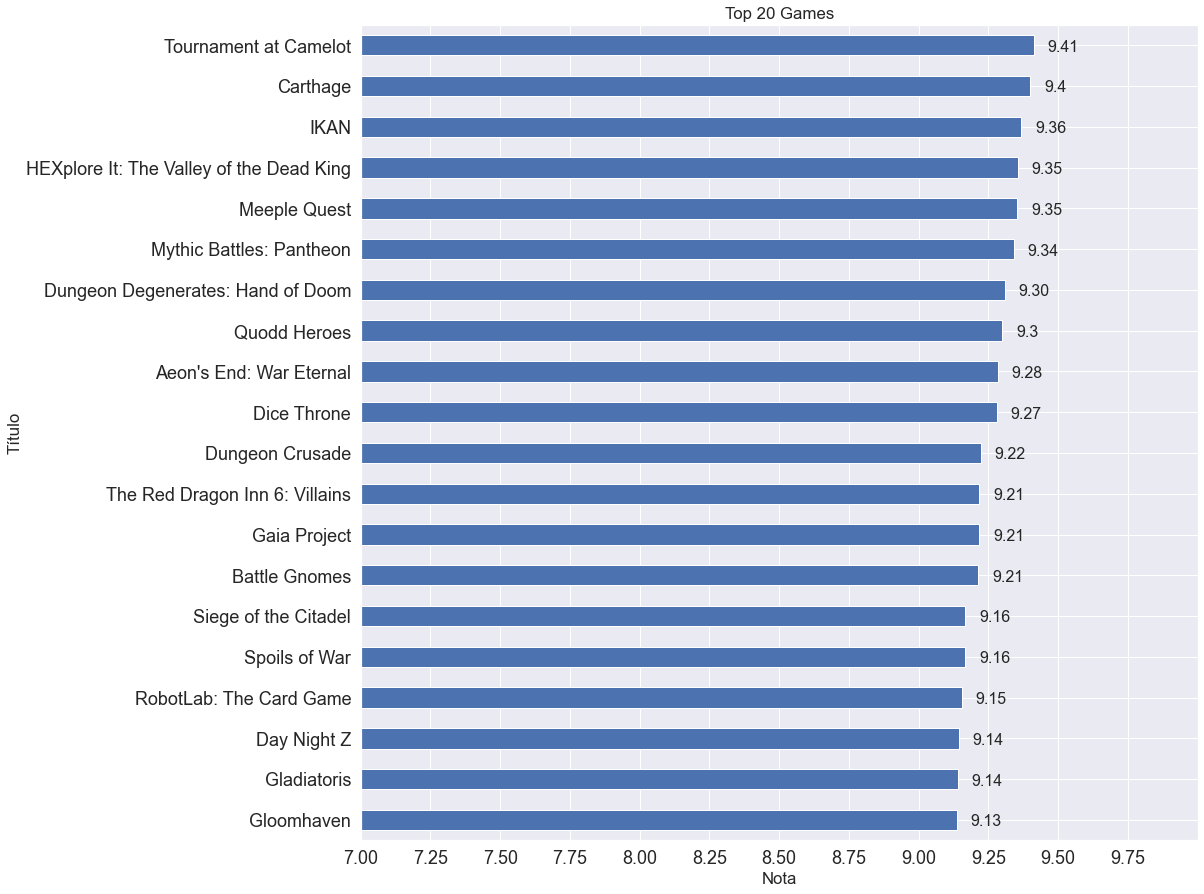

In [67]:
df2 = df.set_index('details.name')
top_games = df2['stats.average'].sort_values(ascending=False)
top_games = top_games[:20]
top_games.sort_values(ascending=True, inplace=True)

plt.figure(figsize=(15,15))
plt.title("Top 20 Games")
ay = top_games.plot.barh(x='stats.average', y='details.name')
plt.xlabel("Nota")
plt.ylabel("Título")
ay.set(xlim=(8, 10))
ay.xaxis.set_ticks(np.arange(7, 10, 0.25))

for tick in ay.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ay.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    
for i, v in enumerate(top_games):
    ay.text(v+.05, i-.15, str(v)[:4], fontsize=16)


## Quem são os melhores game designers?

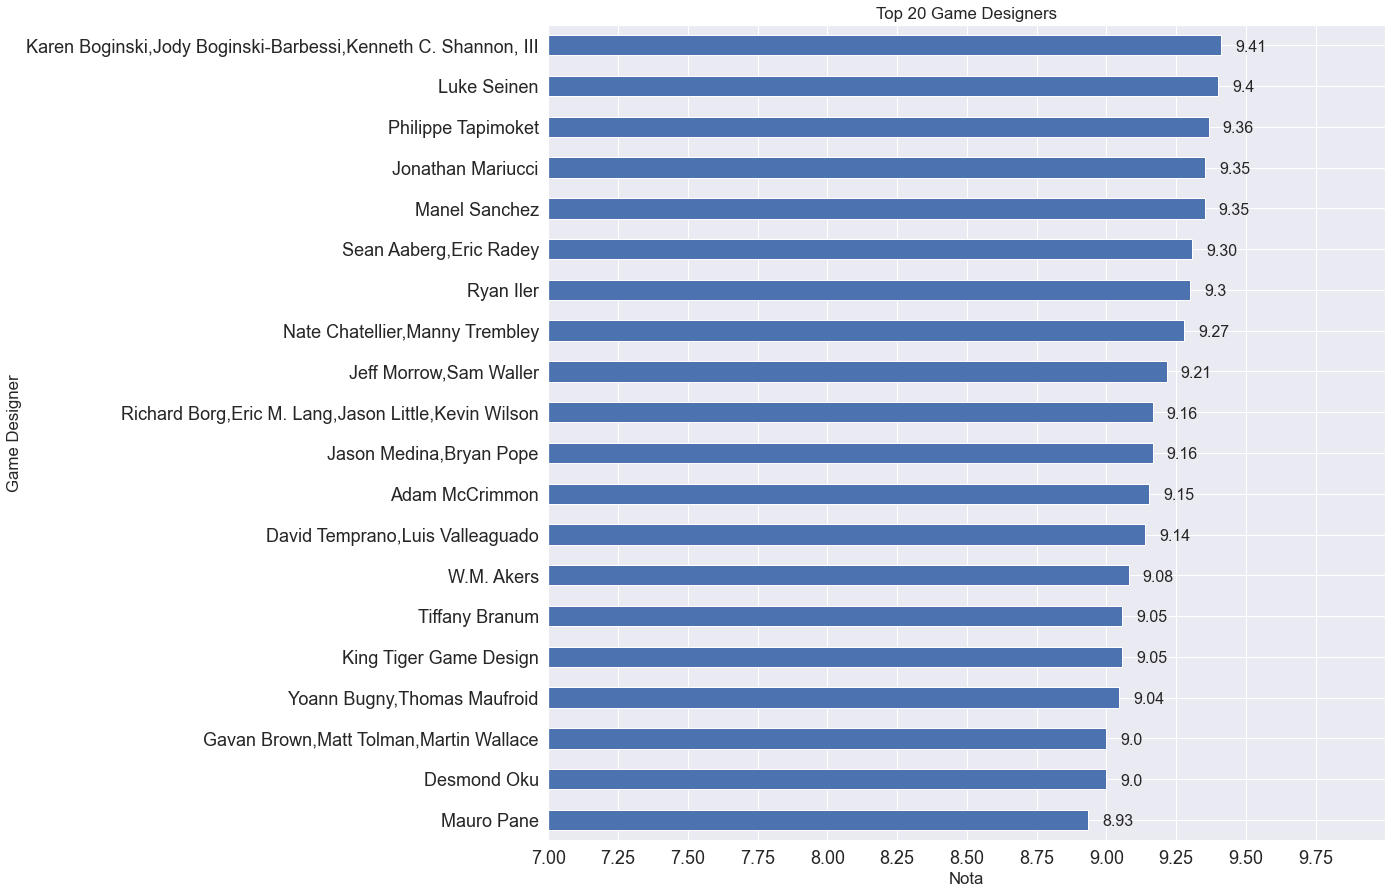

In [68]:
per_game_designer = df.groupby('attributes.boardgamedesigner')['stats.average'].mean()
per_game_designer

top_game_designers = per_game_designer.nlargest(20)
top_game_designers = top_game_designers.sort_values(ascending=True)


plt.figure(figsize=(15,15))
plt.title("Top 20 Game Designers")
ax = top_game_designers.plot.barh()
plt.xlabel("Nota")
plt.ylabel("Game Designer")

ax.set(xlim=(7, 10))
ax.xaxis.set_ticks(np.arange(7, 10, 0.25))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    
for i, v in enumerate(top_game_designers):
    ax.text(v +.05, i-.15, str(v)[:4], fontsize=16)

## Fazer comparação entre os gráficos 
- O primeiro lugar de ambos é o mesmo jogo

## O que define um bom jogo de tabuleiro?
Matriz de correlação entre os atributos do jogo
Podemos verificar a correlação entre a nota do jogo, descrita por _stats.average_ com os outros parâmetros, por exemplo o nível de dificuldade **_stats.averageweight_**, a idade mínima **_details.minage_** e a quantidade máxima e mínima de jogadores, respectivamente **_stats.maxplayers_** e **_stats.minplayers_**.

In [134]:
cmap = sn.choose_diverging_palette(as_cmap=False)


interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

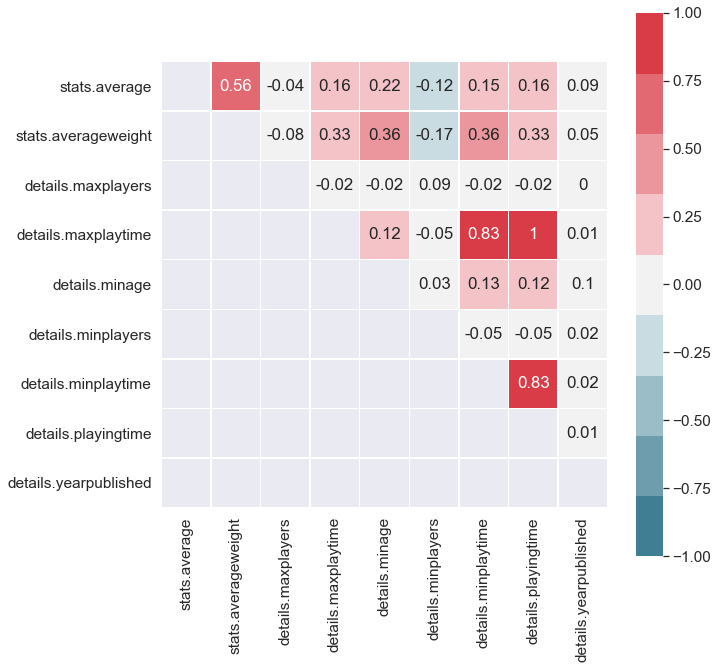

In [46]:
usersrated_100 = df[df['stats.usersrated'] >= 100]
df_corr = ['stats.average', 'stats.averageweight']
for col in usersrated_100:
    if 'details' in col:
        df_corr.append(col)
        
        
sn.set(font_scale=1.4)
df_corr_cols = usersrated_100[df_corr]
df_corr_cols.round(decimals=2)
corrMatrix = df_corr_cols.corr()
mask = np.tril(np.ones_like(corrMatrix, dtype=np.bool))
az = plt.figure(figsize=(10,10))

heatmap = sn.heatmap(corrMatrix.round(decimals=2), mask=mask, linecolor='white', linewidths=.5, 
                     cmap=cmap, vmin=-1, vmax=1, square=True, annot=True)

### Matriz de correlação
Avaliando a matriz de correlação acima, identificamos alguns padrões já esperados, por exemplo, a alta correlação entre o tempo de jogo dos usuários, representado por **_details.playingtime_**, e os tempos mínimos e máximos esperados, respectivamente **_details.minplaytime_** e **_details.maxplaytime_**. É interessante notar também a alta correlação entre a nota do jogo (**_stats.average_**) e sua dificuldade (**_stats.averageweight_**). Isso indica que, de acordo com a comunidade, jogos mais difíceis tendem ter notas mais altas. 

Podemos ver que existe uma certa correlação entre a duração de uma partida e sua dificuldade. De fato, por experiência própria, posso dizer que jogos mais difíceis e complexos, ou seja, com valor de **_stats.averageweight_** alto, tendem a ter partidas bem mais longas que jogos mais simples, os chamados _party games_ ou _fillers_. Também podemos identificar um grau de correlação entre a dificuldade do jogo e a idade mínima, o que já é esperado, crianças muito novas teriam dificuldades com jogos complexos, como _Twilight Imperium_ e _Mage Knight_.



In [76]:
df2 = df.set_index('details.name')
mk_weight = df2.loc['Mage Knight Board Game']['stats.averageweight']
gp_weight = df2.loc['Food Chain Magnate']['stats.averageweight']

print("O grau de dificuldade de Mage Knight é {} e o de Food Chain Magnate é {}, ambos em uma escala de 0 a 5".format(mk_weight.round(decimals=2), gp_weight.round(decimals=2)))

O grau de dificuldade de Mage Knight é 4.21 e o de Food Chain Magnate é 4.18, ambos em uma escala de 0 a 5


### Avaliando a relação entre dificuldade e nota

Vamos ver alguns exemplos que mostram a relação entre dificuldade e nota.

Text(26.89399999999999, 0.5, 'Dificuldade')

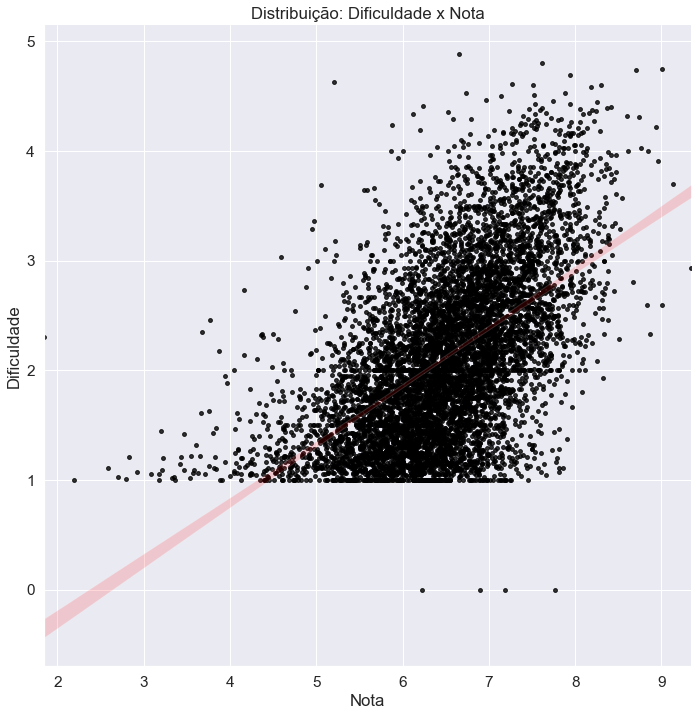

In [161]:
averagexweight = usersrated_100[['details.name', 'stats.averageweight', 'stats.average']]
averagexweight = averagexweight.sort_values('stats.averageweight', ascending=False)

sn.set(font_scale=1.4)
sn.lmplot('stats.average', 'stats.averageweight', averagexweight, 
               scatter_kws={"s": 15, 'color':'black'}, line_kws={'color': 'red'}, height=10)
# \n
plt.title('Distribuição: Dificuldade x Nota')
plt.xlabel('Nota')
plt.ylabel('Dificuldade')
# good_rate